# Importing 

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt


In [2]:
device = torch.device('cuda:0')
print(device)

cuda:0


# Preparing Data

In [68]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
  ])

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [69]:
trainset = torchvision.datasets.ImageFolder(root='/content/drive/My Drive/Covid train test(mutli)/train',transform = transform)
testset = torchvision.datasets.ImageFolder(root='/content/drive/My Drive/Covid train test(mutli)/test',transform = transform)

# My Model

In [65]:
class FirstCNN(nn.Module):

  def __init__(self):
    super(FirstCNN,self).__init__()

    self.conv = nn.Sequential(
        nn.Conv2d(3,32,3), # (N,1,224,224) --> (N,32,222,222)
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #(N,32,111,111)
        
        nn.Conv2d(32,32,3), # (N,32,111,111) --> (N,32,109,109)
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #(N,32,54,54)
        
        nn.Conv2d(32,64,3), #(N,32,54,54) --> (N,64,52,52)
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64,250,3), #(N,250,50,50)
        nn.BatchNorm2d(250),
        nn.ReLU(),
        nn.Conv2d(250,128,3), #(N,128,48,48)
        nn.BatchNorm2d(128),
        nn.AvgPool2d(2,2), #(N,128,24,24)
        
        
        nn.Conv2d(128,64,3), #(N,64,22,22)
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.AvgPool2d(2,2), #(N,64,11,11)
        
        
        nn.Conv2d(64,256,3), #(N,256,9,9)
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #(N,256,4,4)

        
    )
    self.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(4096,32),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(32,3),
        

    )

    

  def forward(self,x):
    x = self.conv(x)
    x = x.view(x.size(0),-1)
    x = self.fc(x)
    return x

In [6]:
def evaluation(dataloader,model):

    total,correct = 0,0
    for data in dataloader:

      inputs,labels = data
      inputs,labels = inputs.to(device),labels.to(device)

      outputs = model(inputs)
      _,pred = torch.max(outputs.data,1)

      correct += (pred == labels).sum().item()
      total += labels.size(0)

    return 100*correct/total


In [7]:
def fit(epochs,loss_fn,opt,model):

  loss_arr = []
  n_iter = 15
  for epoch in range(epochs):
    
    for i,data in enumerate(trainloader):
      
      inputs,labels = data
      inputs,labels = inputs.to(device),labels.to(device)
      opt.zero_grad()
      outputs = model(inputs)
      _,pred = torch.max(outputs.data,1)

      loss = loss_fn(outputs,labels)
      loss.backward()
      opt.step()
      del inputs,labels,outputs
      torch.cuda.empty_cache()
      if(i % 5 == 0):
        print(f'Epoch:{epoch+1}: Iteration {i}/{n_iter}: Loss: {loss.item()}')
        
    loss_arr.append(loss.item())
    print(f'Epoch:{epoch}/{epochs}: The Train Accuracy: {evaluation(trainloader,model)} . The Test Accuracy: {evaluation(testloader,model)}')
      
  

  plt.plot(loss_arr)
  plt.show()

    
  

In [70]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=128,shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=128,shuffle=False)
net = FirstCNN()
net = net.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters(),lr = 0.0001)
fit(10,loss_fn,opt,net)

Epoch:1: Iteration 0/15: Loss: 1.2658154964447021
Epoch:1: Iteration 5/15: Loss: 0.9857210516929626
Epoch:1: Iteration 10/15: Loss: 0.8647100329399109
Epoch:1: Iteration 15/15: Loss: 0.811008095741272
Epoch:0/10: The Train Accuracy: 68.63063795205201 . The Test Accuracy: 54.69135802469136
Epoch:2: Iteration 0/15: Loss: 0.8114188313484192
Epoch:2: Iteration 5/15: Loss: 0.6373491883277893
Epoch:2: Iteration 10/15: Loss: 0.7135936617851257
Epoch:2: Iteration 15/15: Loss: 0.5997185111045837
Epoch:1/10: The Train Accuracy: 77.61072734660706 . The Test Accuracy: 60.864197530864196
Epoch:3: Iteration 0/15: Loss: 0.5924168825149536


KeyboardInterrupt: ignored

This model is overfitting. Tried different combinations but to no success.

# AlexNet

In [72]:
import torchvision.models as model

In [73]:
alex_net = model.alexnet(pretrained=True)
print(alex_net)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [74]:
for param in alex_net.parameters():
  param.requires_grad = False

  

In [75]:
in_features = alex_net.classifier[6].in_features
alex_net.classifier[6] = nn.Linear(in_features,3)

In [76]:
for param in alex_net.parameters():
  if(param.requires_grad ):
    print(param.size())

  

torch.Size([3, 4096])
torch.Size([3])


In [77]:
print(alex_net)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Epoch:1: Iteration 0/15: Loss: 1.3847084045410156
Epoch:1: Iteration 5/15: Loss: 0.9578759074211121
Epoch:1: Iteration 10/15: Loss: 0.7099082469940186
Epoch:1: Iteration 15/15: Loss: 0.629987359046936
Epoch:0/5: The Train Accuracy: 75.57903291344982 . The Test Accuracy: 75.06172839506173
Epoch:2: Iteration 0/15: Loss: 0.588266909122467
Epoch:2: Iteration 5/15: Loss: 0.48971879482269287
Epoch:2: Iteration 10/15: Loss: 0.5120629668235779
Epoch:2: Iteration 15/15: Loss: 0.47378137707710266
Epoch:1/5: The Train Accuracy: 86.02194229987809 . The Test Accuracy: 85.80246913580247
Epoch:3: Iteration 0/15: Loss: 0.3957522511482239
Epoch:3: Iteration 5/15: Loss: 0.4263163208961487
Epoch:3: Iteration 10/15: Loss: 0.3509967625141144
Epoch:3: Iteration 15/15: Loss: 0.33683621883392334
Epoch:2/5: The Train Accuracy: 89.06948394961398 . The Test Accuracy: 90.12345679012346
Epoch:4: Iteration 0/15: Loss: 0.33979928493499756
Epoch:4: Iteration 5/15: Loss: 0.37250831723213196
Epoch:4: Iteration 10/15: L

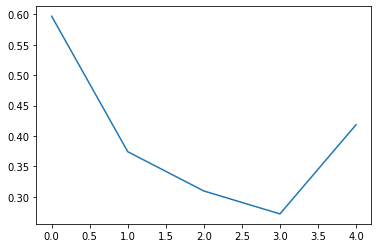

In [78]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=128,shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=128,shuffle=False)

alex_net = alex_net.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(alex_net.parameters(),lr = 0.0001)
fit(5,loss_fn,opt,alex_net)

# Manual Testing

In [29]:
!mkdir covid

In [30]:
!mv *.png covid

In [93]:
loader = transform
from PIL import Image
def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = loader(image).float()
    #image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet

    return image  #assumes that you're using GPU

image = image_loader('aug_set2127.png')
alex_net.eval()
image = image.to(device)
outputs = alex_net(image)
_,pred = torch.max(outputs.data,1)
pred


tensor([0], device='cuda:0')

In [41]:
trainset.class_to_idx

{'covid': 0, 'normal': 1, 'pneumonia': 2}

In [48]:
testset.class_to_idx

{'covid': 0, 'normal': 1, 'pneumonia': 2}

# Confusion Matrix

In [107]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch
        images,labels = images.to(device),labels.to(device)

        preds = model(images)
        preds = preds.to(device)
        all_preds
        all_preds = all_preds.to(device)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
        
    return all_preds

In [108]:
with torch.no_grad():
    testloader_con = torch.utils.data.DataLoader(testset,batch_size=128,shuffle=False)
    alex_net = alex_net.to(device)
    test_preds = get_all_preds(alex_net, testloader_con)

In [138]:
testset = torchvision.datasets.ImageFolder(root='/content/drive/My Drive/Covid train test(mutli)/test',transform = transform)

In [139]:
testset.targets = torch.tensor(testset.targets)

In [140]:
test_preds.argmax(dim=1).shape

torch.Size([810])

In [142]:
test_preds = test_preds.to("cpu")

In [143]:
 stacked = torch.stack(
    (
        testset.targets
        ,test_preds.argmax(dim=1)
    )
    ,dim = 1
)

In [144]:
stacked.shape

torch.Size([810, 2])

In [145]:
stacked

tensor([[0, 1],
        [0, 2],
        [0, 0],
        ...,
        [2, 2],
        [2, 2],
        [2, 2]])

In [147]:
cmt = torch.zeros(3,3, dtype=torch.int64)
cmt


tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]])

In [148]:
for p in stacked:
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1

In [149]:
cmt

tensor([[251,   2,  17],
        [  0, 265,   5],
        [  4,  30, 236]])

**Our Model Performs well with not too many cases predicted wrong.**